# CNN Prototype

Modeling this notebook after the following:

https://nbviewer.jupyter.org/github/dipanjanS/nlp_workshop_dhs18/blob/master/Unit%2012%20-%20Project%209%20-%20Sentiment%20Analysis%20-%20Supervised%20Learning/12B%20-%20Project%2011%20-%20Sentiment%20Analysis%20-%20Advanced%20Deep%20Learning%20-%20CNNs.ipynb


Making the following changes:

* I had trouble figuring out the inputs for the Embedding layer if we used word2vec embedding so using review_body-bow-df_default-ngram12-111909-10020-lda20 instead of word 2 vec since we need to create an embedding layer
* last layer is a 5 node layer with softmax activation function since we are doing a 5 class classification
* Changing the loss function from binary_crossentropy to categorical_crossentropy since we are doing multi-class classification

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping
from keras.models import load_model
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD
from sklearn.preprocessing import OneHotEncoder
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
import pandas as pd
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import dict_util as du
import plot_util as pu
import file_util as fu
import pickle
from datetime import datetime
from sklearn.metrics import confusion_matrix, classification_report
import os

In [0]:
DATE_FORMAT = '%Y-%m-%d'
TIME_FORMAT = '%Y-%m-%d %H:%M:%S'
# DATA_DIR = "dataset/feature_files"
DATA_FILE = "amazon_reviews_us_Wireless_v1_00-preprocessed-50k.csv"
MODEL_NAME = "CNN"
FEATURE_COLUMN = "star_rating"
REVIEW_COLUMN = "review_body"
directory, INBASENAME = fu.get_dir_basename(DATA_FILE)
DESCRIPTION = f"{INBASENAME}-nosmote-{MODEL_NAME}-{FEATURE_COLUMN}"
MODEL_FILE = f"{datetime.now().strftime(DATE_FORMAT)}-{DESCRIPTION}.h5"
NETWORK_HISTORY_FILE = f'{datetime.now().strftime(DATE_FORMAT)}-{DESCRIPTION}-history.pkl'
REPORT_FILE = f"2019-06-18-NN_notebook_protype-report.csv"
TOKENIZER_FILE = f'{datetime.now().strftime(DATE_FORMAT)}-{DESCRIPTION}-tokenizer.pkl'


In [1]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
# df = pd.read_csv(f"{DATA_DIR}/{DATA_FILE}")
df = pd.read_csv(f"{DATA_FILE}")

In [14]:
df.head()

,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,review_headline,review_body,review_date
0,48623501,R1G7J2VAMI4AEC,B00LBK7QBY,361030039,universal waterproof case joto cellphone dry b...,Wireless,5,0,0,good product please note not,good product please note not floating case do ...,2015-08-31
1,533148,R3Q4JAPXWCCJU7,B00W661MOO,360205932,car mount alpatronix mx101 universal charging ...,Wireless,5,0,0,great product holds phone place,great product holds phone place does not slip ...,2015-08-31
2,40266813,RJQWVO0QV2WQ4,B00USN9L0E,105913119,synthetic leather galaxy s6 sleeve thin,Wireless,5,0,0,exactly described,quality looks good prompt postage cannot argue...,2015-08-31
3,228806,R3RFPR7X60WN6C,B00YPAOKMU,564491128,jiake s6 5 0 inch unlocked smart phone quad co...,Wireless,5,0,0,powerful attractive really do love mode,works much like jiake phone love price great b...,2015-08-31
4,10866798,R3QL2UPH2B7YFT,B00O0S97SE,742788022,tfy universal car headrest mount holder portab...,Wireless,3,0,1,good enough,serves purpose loud whoever sitting seat attached,2015-08-31


In [0]:
rating = df[FEATURE_COLUMN]
reviews = df[REVIEW_COLUMN]

**Preprocessing**

In [61]:
# one hot encode ratings
print(rating.shape)
print(type(rating))
y = OneHotEncoder().fit_transform(rating.values.reshape(len(rating), 1)).toarray()
y

(50000,)
<class 'pandas.core.series.Series'>


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

In [0]:
reviews_train, reviews_test, y_train, y_test = train_test_split(reviews, y, random_state=1)

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder

t = Tokenizer()
# fit the tokenizer on the documents
t.fit_on_texts(reviews_train)

In [0]:
train_sequences = t.texts_to_sequences(reviews_train)

In [39]:
train_sequences[:2]

[[13, 35, 231, 352, 43, 3, 34, 35, 44, 201, 110, 3463],
 [169,
  3,
  355,
  623,
  1018,
  66,
  453,
  83,
  355,
  941,
  176,
  59,
  2,
  59,
  209,
  756,
  325,
  43,
  173,
  3385,
  5279,
  23,
  83,
  36,
  355,
  67,
  1246,
  199,
  275,
  5423,
  131,
  427,
  7971]]

In [52]:
test_sequences = t.texts_to_sequences(reviews_test)
test_sequences[:2]

[[1524, 2, 35, 58, 236, 84, 6345, 2, 158],
 [107,
  10,
  164,
  26,
  22,
  1,
  78,
  676,
  29,
  85,
  5623,
  4,
  581,
  389,
  33,
  27,
  20,
  586]]

In [46]:
print("Vocabulary size={}".format(len(t.word_counts)))
print("Number of Documents={}".format(t.document_count))

Vocabulary size=20701
Number of Documents=37500


**Sequence Normalization**

Figure out max length of review and pad the rest so they are all the same length

In [47]:
df["review_length"] = df.review_body.apply(lambda x: len(x.split()))
df.review_length.max()

2855

In [48]:
df.describe()

,customer_id,product_parent,star_rating,helpful_votes,total_votes,review_length
count,5.000000e+04,5.000000e+04,50000.00000,50000.000000,50000.000000,50000.000000
mean,2.320570e+07,5.002260e+08,3.98146,0.590900,0.800500,18.482800
std,1.638811e+07,2.874457e+08,1.43968,8.560678,9.088562,39.012975
min,1.014100e+04,2.045200e+04,1.00000,0.000000,0.000000,1.000000
25%,9.621004e+06,2.525153e+08,3.00000,0.000000,0.000000,4.000000
50%,2.072055e+07,5.021919e+08,5.00000,0.000000,0.000000,9.000000
75%,3.836945e+07,7.456658e+08,5.00000,0.000000,0.000000,20.000000
max,5.309605e+07,9.999930e+08,5.00000,1369.000000,1392.000000,2855.000000


In [49]:
df.quantile([0.95])

,customer_id,product_parent,star_rating,helpful_votes,total_votes,review_length
0.95,50121569.95,9.483259e+08,5.0,2.0,3.0,64.0


Looks like 95% of our reviews have 64 words or less. If we keep our sequence length to around 64 words, this should allow us to keep most of our content

NOTE: no need to do encoding for our star_ratings since this is already in a number format

In [0]:
MAX_SEQUENCE_LENGTH = 65
# pad dataset to a maximum review length in words
X_train = sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [55]:
X_train[:2]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,   13,   35,
         221,  362,   44,    3,   34,   35,   42,  180,  113, 3438],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,  170,
           3,  371,  629, 1060,   68,  457,   84,  371,  960,  175,   60,
           2,   60,  212,  701,  330,   44,  171, 3207, 8704,   23,   84,
          36,  371,   69, 1253,  191,  276, 4563,  130,  408, 6405]],
      dtype=int32)

In [56]:
rating.head()

0    5
1    5
2    5
3    5
4    3
Name: star_rating, dtype: int64

In [0]:
EMBED_SIZE = 32
EPOCHS  = 50
BATCH_SIZE = 128
VOCAB_SIZE = len(t.word_counts)+1


In [0]:
model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [70]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 65, 32)            662464    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 65, 32)            3104      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 32, 32)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 250)               256250    
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 1255      
Total params: 923,073
Trainable params: 923,073
Non-trainable params: 0
_________________________________________________________________
None

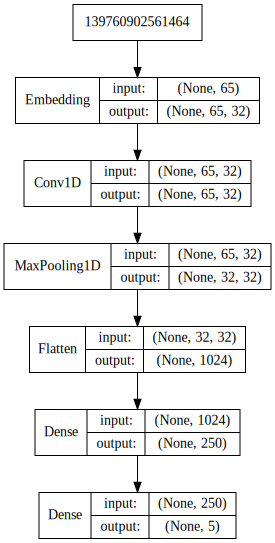

In [71]:
SVG(model_to_dot(model, show_shapes=True, show_layer_names=False, 
                 rankdir='TB').create(prog='dot', format='svg'))

In [72]:
early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
network_history = model.fit(x_train, y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      verbose=1,
                      validation_split=0.2,
                      callbacks=[early_stop])

Train on 30000 samples, validate on 7500 samples
Epoch 1/50
30000/30000 [==============================] - 2s 50us/step - loss: 1.0274 - acc: 0.6272 - val_loss: 0.8777 - val_acc: 0.6711
Epoch 2/50
30000/30000 [==============================] - 1s 37us/step - loss: 0.7872 - acc: 0.6995 - val_loss: 0.8487 - val_acc: 0.6829
Epoch 3/50
30000/30000 [==============================] - 1s 38us/step - loss: 0.6612 - acc: 0.7487 - val_loss: 0.8954 - val_acc: 0.6795
Epoch 4/50
30000/30000 [==============================] - 1s 37us/step - loss: 0.5554 - acc: 0.7939 - val_loss: 0.9768 - val_acc: 0.6681
Epoch 00004: early stopping


In [73]:
scores = model.evaluate(x_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))


12500/12500 [==============================] - 1s 47us/step
Accuracy: 66.86%


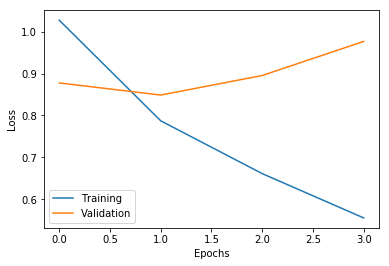

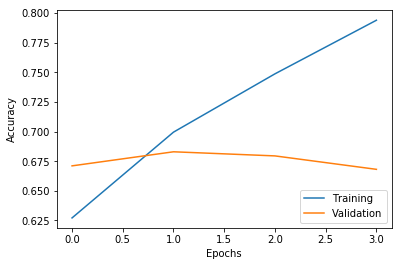

In [74]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(network_history.history['acc'])
    plt.plot(network_history.history['val_acc'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

plot_history(network_history)

In [0]:
y_predict = model.predict(x_test)

In [76]:
y_predict_df = pd.DataFrame(y_predict)
y_predict_df.head()

,0,1,2,3,4
0,2.974109e-07,0.000001,0.000037,0.010241,0.989720
1,2.066096e-04,0.001669,0.022830,0.317898,0.657397
2,6.945325e-01,0.235931,0.060389,0.006938,0.002210
3,3.058089e-01,0.204984,0.242809,0.132938,0.113460
4,2.320589e-02,0.025703,0.156537,0.425332,0.369223


In [0]:
y_predict_unencoded = [row.idxmax() + 1 for index, row in y_predict_df.iterrows()]

In [0]:
y_test_df = pd.DataFrame(y_test)
y_test_unencoded = [row.idxmax() + 1 for index, row in y_test_df.iterrows()]

In [79]:
confusion_matrix(y_test_unencoded, y_predict_unencoded)

array([[1249,   95,  120,   57,  130],
       [ 376,   82,  156,   94,  102],
       [ 215,   69,  216,  265,  238],
       [  86,   32,  174,  539, 1055],
       [ 123,   22,  141,  592, 6272]])

In [80]:
print(classification_report(y_test_unencoded, y_predict_unencoded))

              precision    recall  f1-score   support

           1       0.61      0.76      0.68      1651
           2       0.27      0.10      0.15       810
           3       0.27      0.22      0.24      1003
           4       0.35      0.29      0.31      1886
           5       0.80      0.88      0.84      7150

    accuracy                           0.67     12500
   macro avg       0.46      0.45      0.44     12500
weighted avg       0.63      0.67      0.65     12500



# Save off various files

In [0]:
model.save(MODEL_FILE)

In [0]:
pickle.dump(network_history, open(NETWORK_HISTORY_FILE, "wb"))

In [0]:
pickle.dump(t, open(TOKENIZER_FILE, "wb"))

In [0]:
# saving off report in the same format as other report just in case we want to compare for later
flattened = {}
flattened = du.add_dict_to_dict(flattened, classification_report(y_test_unencoded, y_predict_unencoded, output_dict=True))
flattened["confusion_matrix"] = confusion_matrix(y_test_unencoded, y_predict_unencoded)
flattened["description"] = DESCRIPTION
flattened["file"] = DATA_FILE
flattened["network_history_file"] = NETWORK_HISTORY_FILE
flattened["tokenizer_file"] = TOKENIZER_FILE
flattened["embedding"] = "bow"
flattened["model_file"] = MODEL_FILE
flattened["model_name"] = MODEL_NAME
flattened["test_examples"] = x_test.shape[0]
flattened["test_features"] = x_test.shape[1]
flattened["train_examples"] = x_train.shape[0]
flattened["train_features"] = x_train.shape[1]
flattened["status"] = "success"
flattened["status_date"] = datetime.now().strftime(TIME_FORMAT)


In [91]:
# check to see if report file exisits, if so load it and append
exists = os.path.isfile(REPORT_FILE)
if exists:
    report_df = pd.read_csv(REPORT_FILE)
else:
    report_df = pd.DataFrame()
    
report_df = report_df.append(flattened, ignore_index=True)
report_df.head()



,1_f1-score,1_precision,1_recall,1_support,2_f1-score,2_precision,2_recall,2_support,3_f1-score,3_precision,3_recall,3_support,4_f1-score,4_precision,4_recall,4_support,5_f1-score,5_precision,5_recall,5_support,accuracy,confusion_matrix,description,embedding,file,macro avg_f1-score,macro avg_precision,macro avg_recall,macro avg_support,model_file,model_name,network_history_file,status,status_date,test_examples,test_features,tokenizer_file,train_examples,train_features,weighted avg_f1-score,weighted avg_precision,weighted avg_recall,weighted avg_support
0,0.675135,0.609566,0.756511,1651.0,0.147748,0.273333,0.101235,810.0,0.238674,0.267658,0.215354,1003.0,0.314011,0.348416,0.28579,1886.0,0.839232,0.804412,0.877203,7150.0,0.66864,"[[1249, 95, 120, 57, 130], [376, 82, 156, 94, ...",amazon_reviews_us_Wireless_v1_00-preprocessed-...,bow,amazon_reviews_us_Wireless_v1_00-preprocessed-...,0.44296,0.460677,0.447219,12500.0,2019-06-23-amazon_reviews_us_Wireless_v1_00-pr...,CNN,2019-06-23-amazon_reviews_us_Wireless_v1_00-pr...,success,2019-06-23 04:04:55,12500.0,65.0,2019-06-23-amazon_reviews_us_Wireless_v1_00-pr...,37500.0,65.0,0.645316,0.632393,0.66864,12500.0


In [0]:
report_df.to_csv(REPORT_FILE, index=False)